In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import DataLoader, random_split
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_data(dir_list, image_size):
    X = []
    y = []
    
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # crop the brain and ignore the unnecessary rest part of the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])  
                
    X = np.array(X)
    y = np.array(y)
    
    
    # Shuffle the data
    X, y = shuffle(X, y)

    # X = torch.tensor(X.transpose(0,3,1,2))

    
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')


    
    return X, y

In [4]:
augmented_path = 'C:/Users/aytem/Desktop/testgit/5820-Final-Project/5820-Final-Project/data'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = augmented_path + '/yes' 
data_no = augmented_path + '/no'


IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [5]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

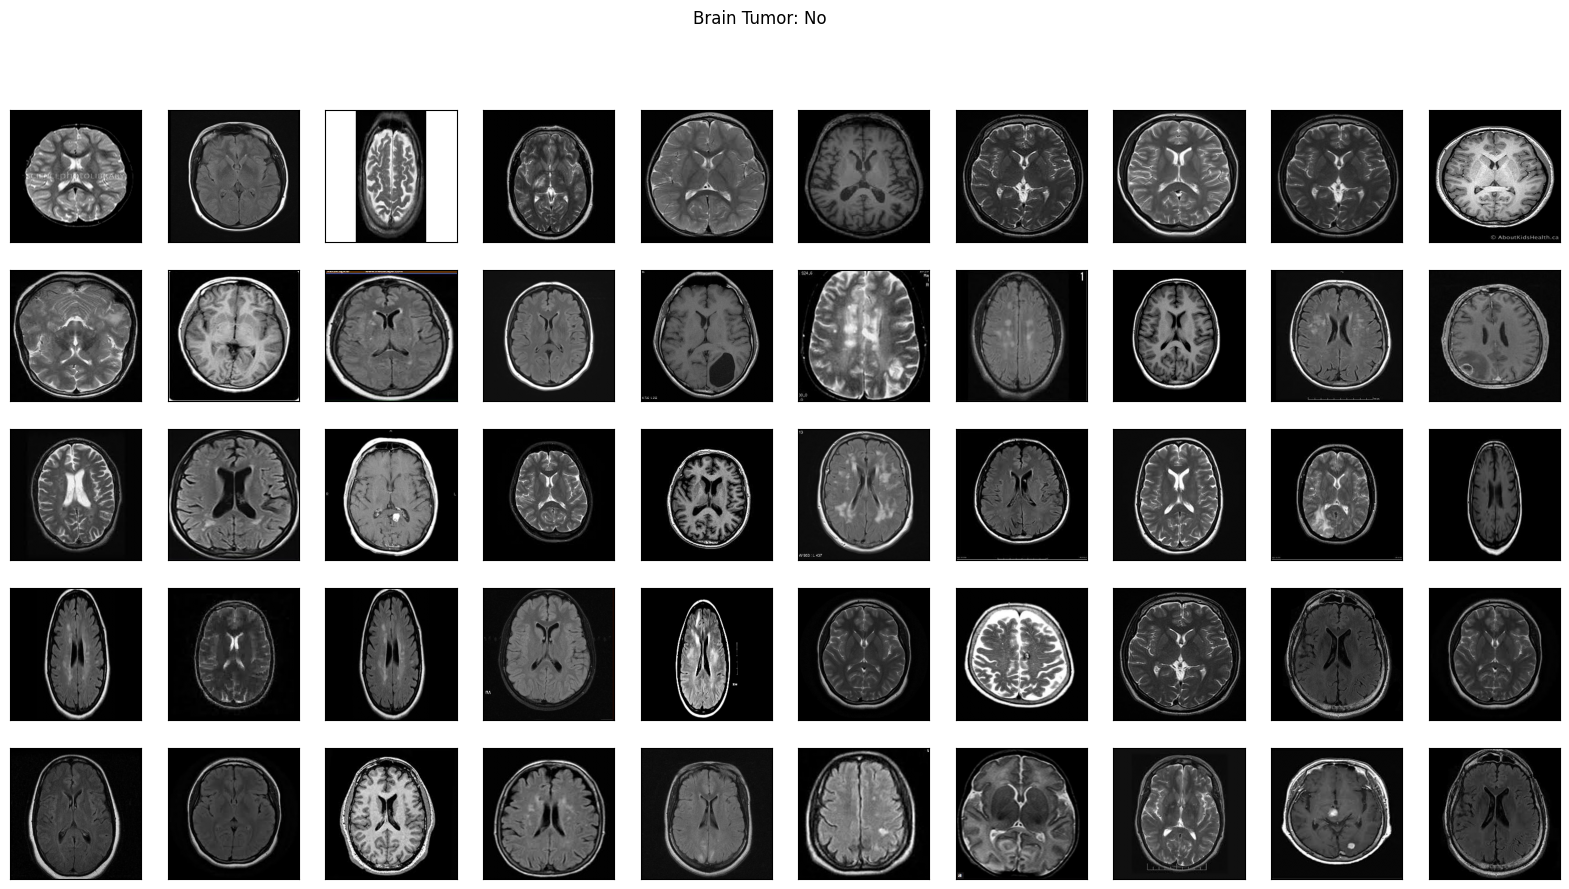

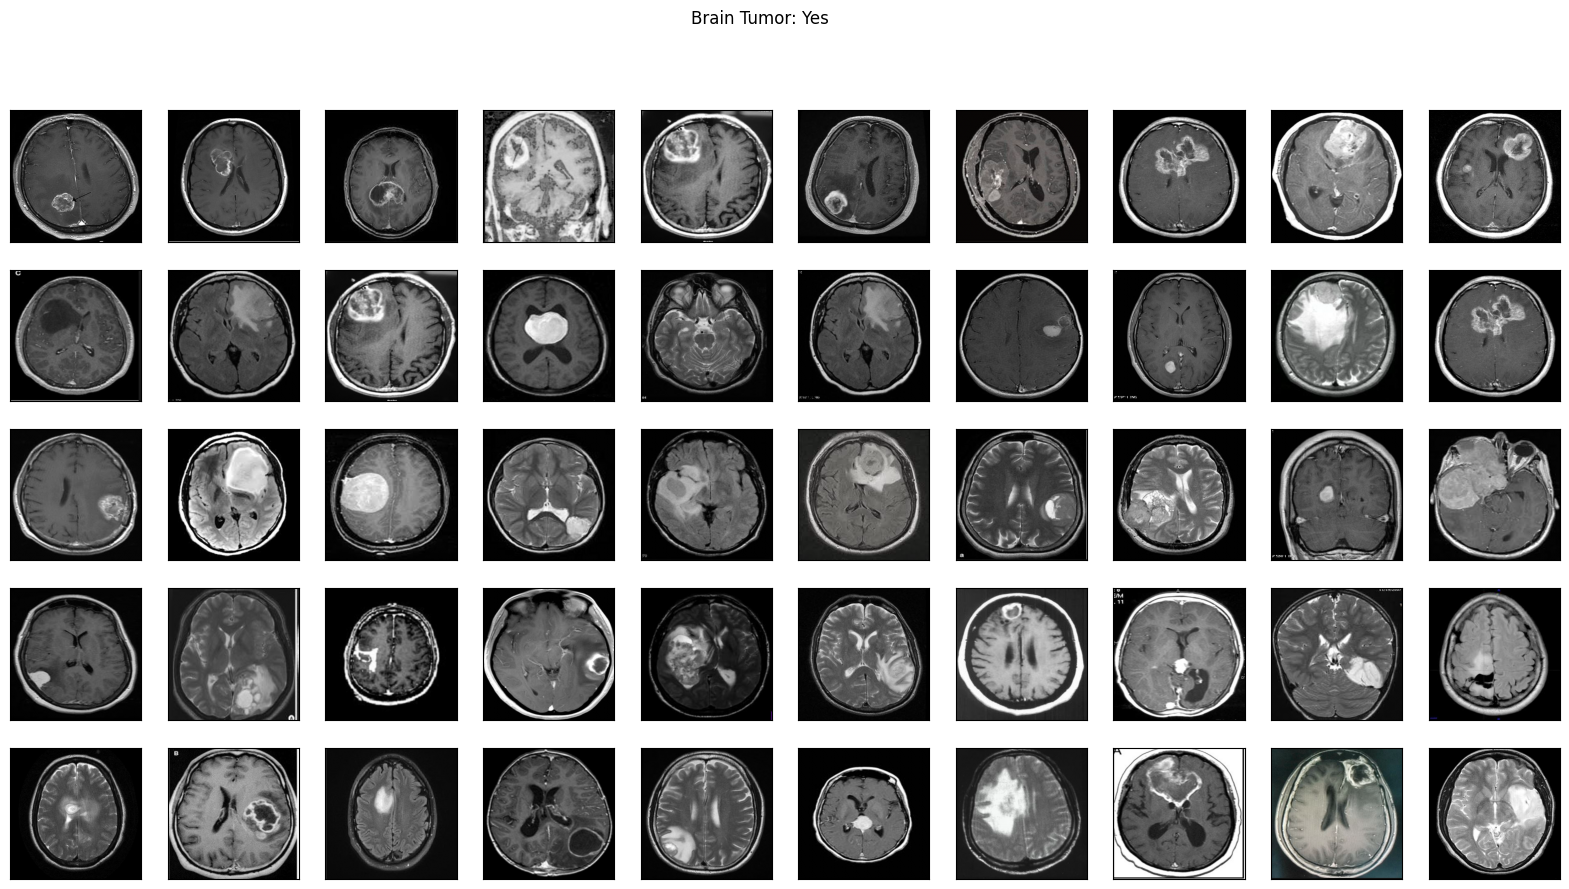

In [6]:
plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = split_data(X, y, test_size=0.3)

In [9]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

training_data = torch.utils.data.TensorDataset(X_train, y_train)
testing_data = torch.utils.data.TensorDataset(X_test, y_test)


In [10]:
import torch.utils
import torch.utils.data

train_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testing_data, batch_size=10, shuffle=False)

In [11]:
print('Training set has {} instances'.format(len(training_data)))
print('Validation set has {} instances'.format(len(testing_data)))

Training set has 177 instances
Validation set has 76 instances


In [12]:
IMG_SHAPE = (240, 240, 3) 
class BrainDetectionModel(nn.Module):
    def __init__(self, input_shape):
        super(BrainDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 4))
        self.fc1 = nn.Linear(6272, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.dropout2(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

model = BrainDetectionModel(IMG_SHAPE)


In [13]:
from torchsummary import summary
summary(model, input_size=IMG_SHAPE)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─MaxPool2d: 1-7                         --
├─Linear: 1-8                            6,273
├─Sigmoid: 1-9                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─MaxPool2d: 1-7                         --
├─Linear: 1-8                            6,273
├─Sigmoid: 1-9                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0

In [14]:
from torchmetrics import ConfusionMatrix

In [15]:
val_losses = []
train_losses = []
val_accuracy = []
traning_accuracy = []

def train_dataset(model, train_loader, validation_loader):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    
    num_epochs = 50
    

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.transpose(1,3).transpose(2,3)   
            inputs, labels = inputs.to(device), labels.to(device)        
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            epoch_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            predicted = predicted.to(device)
            labels = labels.float().to(device)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)    

        epoch_loss /= len(train_loader.dataset)
        accuracy = correct / total

        train_losses.append(epoch_loss)
        traning_accuracy.append(accuracy)



        print(f"Epoch [{epoch + 1}/{num_epochs}]\nTrain Loss: {epoch_loss:.4f}, Train Acc: {accuracy:.4f}")


        # Validation
        model.eval()  # Set the model to evaluation mode
        epoch_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.transpose(1,3).transpose(2,3)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item() * inputs.size(0)

                predicted = (outputs > 0.5).float()
                predicted = predicted.to(device)
                labels = labels.float().to(device)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)    

        epoch_loss /= len(validation_loader.dataset)
        accuracy = correct / total

        val_accuracy.append(accuracy)


        epoch_loss /= len(validation_loader.dataset)
        val_losses.append(epoch_loss)

        print(f"Val Loss: {epoch_loss:.4f}, Val Acc: {accuracy:.4f}")

In [16]:
train_dataset(model, train_loader, validation_loader)

Epoch [1/50]
Train Loss: 2.3688, Train Acc: 0.6328
Val Loss: 0.0092, Val Acc: 0.7105
Epoch [2/50]
Train Loss: 0.8907, Train Acc: 0.7571
Val Loss: 0.0068, Val Acc: 0.7763
Epoch [3/50]
Train Loss: 0.5454, Train Acc: 0.7910
Val Loss: 0.0063, Val Acc: 0.7632
Epoch [4/50]
Train Loss: 0.6318, Train Acc: 0.7853
Val Loss: 0.0099, Val Acc: 0.6842
Epoch [5/50]
Train Loss: 0.4462, Train Acc: 0.8249
Val Loss: 0.0079, Val Acc: 0.7500
Epoch [6/50]
Train Loss: 0.3905, Train Acc: 0.8418
Val Loss: 0.0071, Val Acc: 0.7632
Epoch [7/50]
Train Loss: 0.3346, Train Acc: 0.8814
Val Loss: 0.0084, Val Acc: 0.6711
Epoch [8/50]
Train Loss: 0.2727, Train Acc: 0.8983
Val Loss: 0.0080, Val Acc: 0.7763
Epoch [9/50]
Train Loss: 0.2662, Train Acc: 0.8983
Val Loss: 0.0095, Val Acc: 0.7368
Epoch [10/50]
Train Loss: 0.2482, Train Acc: 0.9266
Val Loss: 0.0066, Val Acc: 0.7895
Epoch [11/50]
Train Loss: 0.2745, Train Acc: 0.8927
Val Loss: 0.0077, Val Acc: 0.7895
Epoch [12/50]
Train Loss: 0.3559, Train Acc: 0.8870
Val Loss: 0

In [17]:
print("val loss: ",val_losses)
print("train loss: ",train_losses)

val loss:  [0.009188411076271963, 0.006789713200192043, 0.006334362543830416, 0.009872256171917981, 0.007916851748307327, 0.007099158643974492, 0.008405815696452134, 0.007952099526688003, 0.009506428687784233, 0.006623031394788351, 0.007666660786201337, 0.008905192230856484, 0.0058044722243121875, 0.00766902804372115, 0.008178055288987312, 0.007817933922814118, 0.006625318141922437, 0.007224113034817114, 0.006440802605002293, 0.00829609832694171, 0.005820316467318075, 0.0054096798315757776, 0.006458016409773452, 0.006354771117187025, 0.007087698553455349, 0.006240503548404558, 0.005688137925453123, 0.0059488727675668296, 0.007107475187843587, 0.007861720883078523, 0.006684431669152654, 0.007538449238560748, 0.006921611479747979, 0.008635892280102694, 0.008481306318481326, 0.006405551509268664, 0.007913915184552206, 0.009342048315339723, 0.006734606513837056, 0.009707093672324462, 0.007925368108555425, 0.007427009261818538, 0.00918288005711356, 0.006476283768047463, 0.007672445563914853

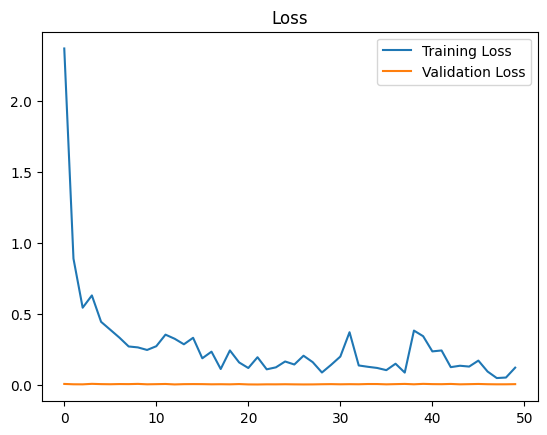

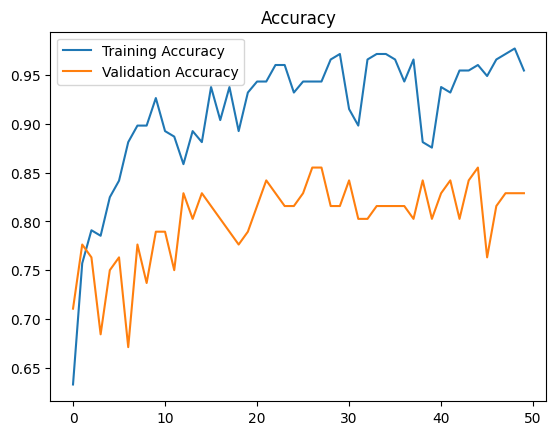

In [18]:
import matplotlib.pyplot as plt
# Loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(traning_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

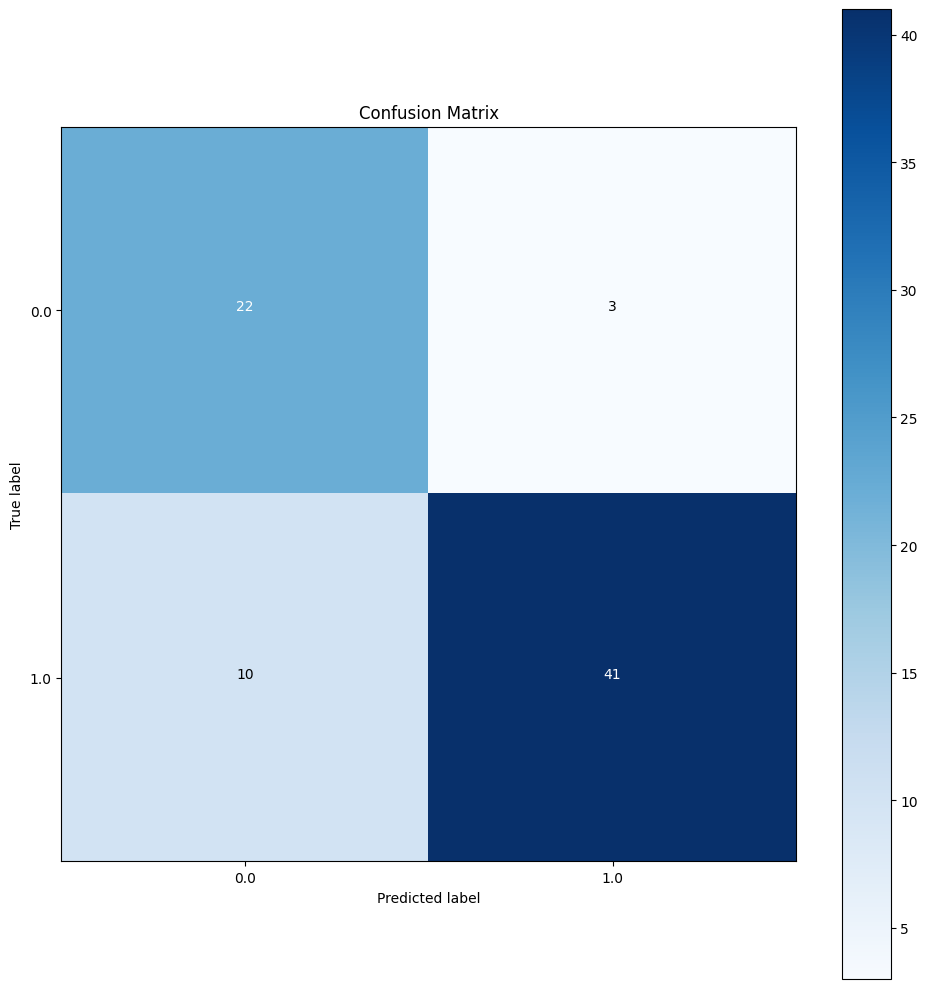

In [27]:
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

model.eval() 
with torch.no_grad():
    outputs = model(X_test.transpose(1,3).transpose(2,3))
    predictions = (outputs >= 0.5).float()

y_predict = predicted.cpu().numpy().squeeze()
y_true = y_test.numpy().squeeze()

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_true, y_predict)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


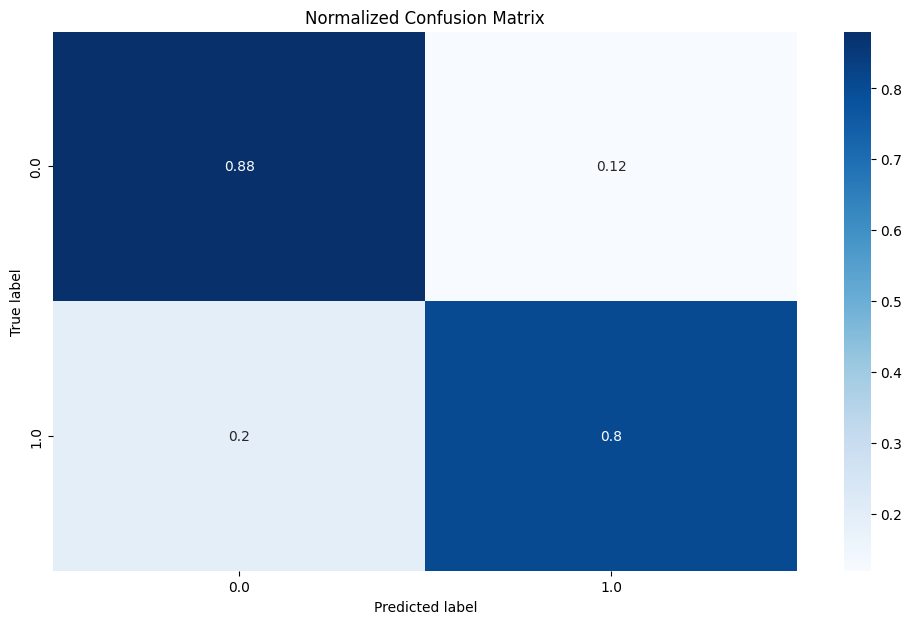

F1 score: 0.8631578947368421


In [30]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Assuming you have your true labels 'y_true' and predicted labels 'y_pred' already defined

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_predict)

# Normalize confusion matrix
normalized_cf_matrix = cf_matrix / np.sum(cf_matrix, axis=1)[:, None]

# Get the unique classes
classes = np.unique(y_true)

# Create DataFrame from normalized confusion matrix
df_cm = pd.DataFrame(normalized_cf_matrix, index=classes, columns=classes)

# Plot confusion matrix
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate F1 score
f1 = f1_score(y_true, y_predict)
print("F1 score:", f1)
